# DATA MINING PROJECT - PROTEIN BLOCKS

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import Image, Markdown

In [2]:
pd.set_option('display.max_rows', 50)

In [3]:
df = pd.read_csv("March_2024_PDB_01.txt", sep=r"\s+", header=None)
df.columns = ['Protein_number', 'PB1', 'PB2', 'expected_frequency', 'AA1', 'AA2', 'S2_1', 'S2_2']
df

,Protein_number,PB1,PB2,expected_frequency,AA1,AA2,S2_1,S2_2
0,1,p,f,0.941295,H,E,C,S
1,1,f,c,0.322290,W,P,S,S
2,1,o,l,0.412006,T,Q,C,C
3,3,b,i,0.298008,V,G,C,C
4,4,j,c,0.151741,G,R,E,E
...,...,...,...,...,...,...,...,...
5370,1720,n,p,0.202308,C,L,S,C
5371,1720,g,m,0.088315,S,E,T,T
5372,1720,h,o,0.194438,K,K,S,S
5373,1720,b,i,0.298008,P,N,C,C


## Unexpected transitions between protein blocks

In [4]:
def filter_data_set(data, rm_columns : list, req_col_str : str):
    """
    Input:  data is data set to be filtered,
            rm_columns is list of column names as strings to be removed, 
            req_col_str is a string of a new column name with "-"
    """
    data = data.drop(rm_columns, axis=1)
    data[req_col_str] = ""
    for req_col in req_col_str.split('-'):
        data[req_col_str] += data[req_col].str.upper()
        
    value_counts = data[req_col_str].value_counts()
    
    data = data.drop_duplicates(subset=[req_col_str])
    data[req_col_str + '-count'] = data[req_col_str].map(value_counts)
        
    data = data.sort_values(by=str(req_col_str + '-count'), ascending=True).reset_index(drop=True)
    return data, value_counts

In [5]:
df_u_t, value_counts = filter_data_set(df, list(('Protein_number', 'expected_frequency', 'AA1', 'AA2', 'S2_1', 'S2_2')), 'PB1-PB2')
total = df.shape[0]
ut_c = [] # unexpected transitions count
for value_count in value_counts:
    if value_count * 100 / total < 1: # if the transition occurs in less than 1% of cases
        ut_c.append(value_count)
ut_c = list(set(ut_c)) # removing duplicates
df_u_t = df_u_t[df_u_t['PB1-PB2-count'].isin(ut_c)]
df_u = df_u_t.reset_index(drop=True)
df_u

,PB1,PB2,PB1-PB2,PB1-PB2-count
0,m,e,ME,1
1,o,h,OH,1
2,f,j,FJ,1
3,o,a,OA,1
4,f,l,FL,1
...,...,...,...,...
101,p,n,PN,47
102,k,i,KI,48
103,a,a,AA,51
104,p,k,PK,52


In [6]:
df = df[df[['PB1','PB2']].apply(tuple, axis=1).isin(df_u[['PB1','PB2']].apply(tuple, axis=1))].reset_index(drop=True)
df

,Protein_number,PB1,PB2,expected_frequency,AA1,AA2,S2_1,S2_2
0,3,b,i,0.298008,V,G,C,C
1,4,j,c,0.151741,G,R,E,E
2,4,p,n,0.726866,G,E,C,T
3,4,a,a,0.000000,G,G,S,S
4,6,g,a,0.194215,G,G,S,C
...,...,...,...,...,...,...,...,...
1505,1718,f,g,0.895978,D,T,C,C
1506,1719,g,n,0.205588,W,E,T,T
1507,1720,n,p,0.202308,C,L,S,C
1508,1720,h,o,0.194438,K,K,S,S


In [7]:
def visualize_frequency(data, col, top_n=20):
    """
    col is a name of visualized structure as string
    """
    total = data.iloc[:, -1].sum()
    labels = data.iloc[:, -2]
    sizes = data.iloc[:, -1] / total
    
    sorted_indices = sizes.argsort()[::-1]
    labels = labels.iloc[sorted_indices]
    sizes = sizes.iloc[sorted_indices] 
    labels = labels[:top_n]
    sizes = sizes[:top_n]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    if col == 'amino acid':
        color = 'lightcoral'
    elif col == 'secondary structure':
        color = 'skyblue'
    else:
        color = 'plum'
        
    ax.barh(labels, sizes, color=color)
    
    ax.set_xlabel("Proportion")
    ax.set_ylabel(col)
    ax.set_title(f"Frequency of {col} pairs in unexpected transitions between protein blocks")
    # invert y-axis so the most frequent category is at the top
    ax.invert_yaxis()
    
    plt.xticks(rotation=45)
    plt.show()

## Determining amino acids associated with unexpected transitions

In [8]:
df_aa, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency', 'S2_1', 'S2_2')), 'AA1-AA2')
df_aa

,AA1,AA2,AA1-AA2,AA1-AA2-count
0,D,W,DW,1
1,b,G,BG,1
2,Q,F,QF,1
3,C,P,CP,1
4,S,C,SC,1
...,...,...,...,...
332,G,R,GR,26
333,G,a,GA,27
334,G,L,GL,31
335,G,S,GS,35


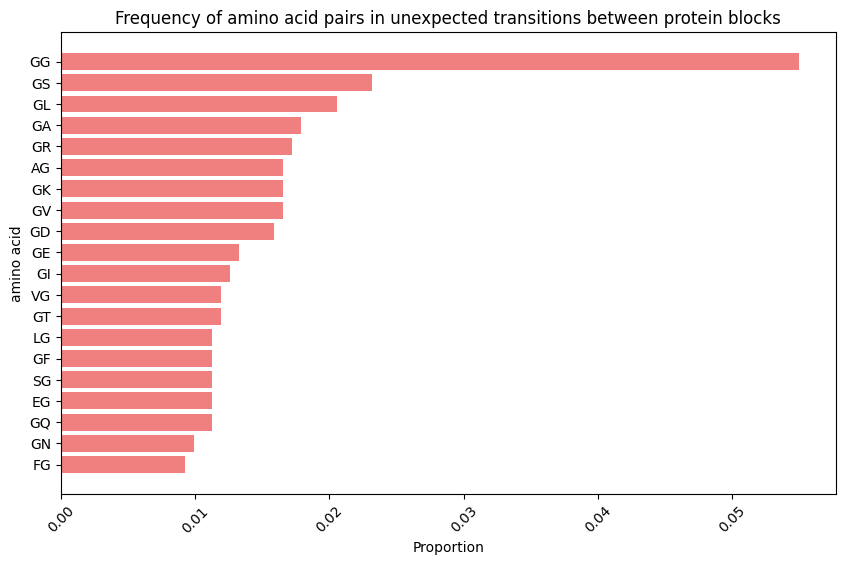

In [9]:
visualize_frequency(df_aa, 'amino acid')

#### The most frequent amino acid pair in unexpected transitions between protein blocks is GG.

## Determining secondary structures associated with unexpected transitions

In [10]:
df_s2, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency', 'AA1', 'AA2')), 'S2_1-S2_2')
df_s2

,S2_1,S2_2,S2_1-S2_2,S2_1-S2_2-count
0,I,I,II,1
1,I,H,IH,1
2,B,H,BH,1
3,T,H,TH,1
4,B,T,BT,1
5,B,E,BE,1
6,I,S,IS,1
7,B,B,BB,1
8,S,E,SE,2
9,I,C,IC,2


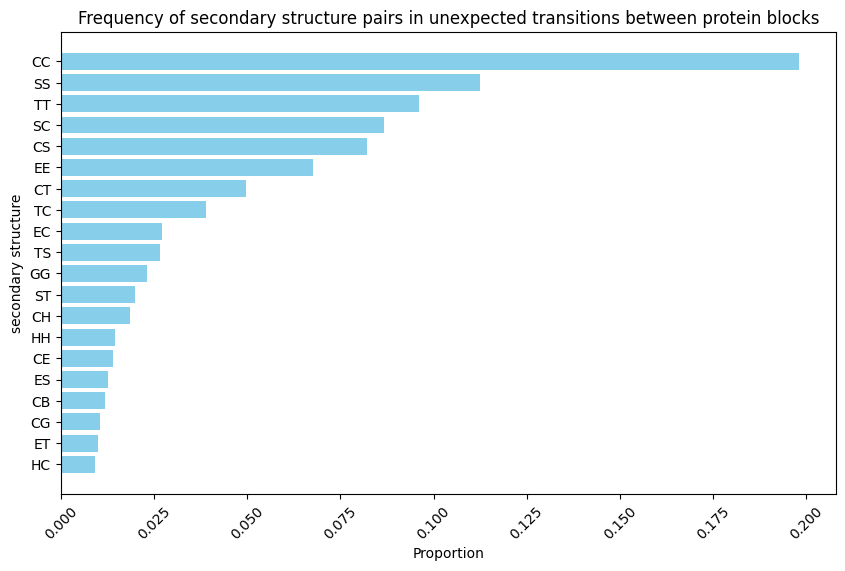

In [11]:
visualize_frequency(df_s2, 'secondary structure')

#### The most frequent secondary structure pair in unexpected transitions between protein blocks is CC.

## Determining which (AA1, AA2) & (S2_1, S2_2) combinations are in the transitions

In [12]:
df_aa_s2, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency')), 'AA1-AA2-S2_1-S2_2')
df_aa_s2

,AA1,AA2,S2_1,S2_2,AA1-AA2-S2_1-S2_2,AA1-AA2-S2_1-S2_2-count
0,R,G,S,C,RGSC,1
1,N,R,S,T,NRST,1
2,D,G,E,E,DGEE,1
3,N,E,C,T,NECT,1
4,I,E,C,B,IECB,1
...,...,...,...,...,...,...
1069,G,a,T,T,GATT,7
1070,G,G,E,C,GGEC,8
1071,G,G,T,T,GGTT,9
1072,G,G,S,C,GGSC,9


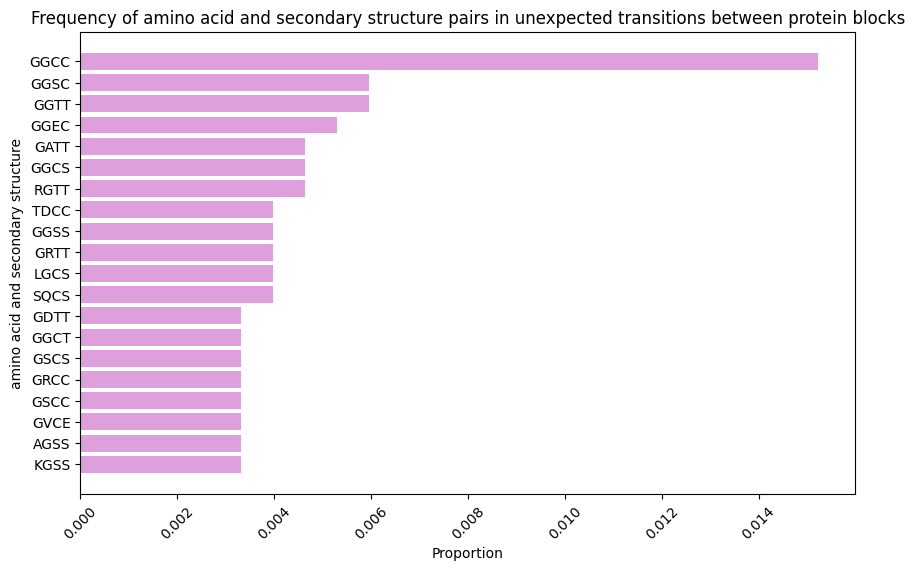

In [13]:
visualize_frequency(df_aa_s2, 'amino acid and secondary structure')

#### The most frequent (AA1, AA2) & (S2_1, S2_2) combination in unexpected transitions between protein blocks is GG CC.

## pLDDT value

In [14]:
Image(url="https://ftp.ebi.ac.uk/pub/training/2024/On-demand/pLDDT_fixed.gif")

#### pLDDT values range from 0 to 100 and pLDDT ≥ 90 indicates residues predicted with extremely high confidence, whereas residues with 90 > pLDDT ≥ 70 are classified as confident. 

In [15]:
df1 = pd.read_csv("March_2024_AF2_01.txt", sep=r"\s+", header=None)
df1.columns = ['Protein_number', 'res_number', 'PB1', 'PB2', 'AA1', 'AA2', 'S2_1', 'S2_2', 'expected_frequency', 'plDDT', 'RSA1', 'RSA2']
df1

,Protein_number,res_number,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,0,7,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,1,95,n,l,E,Q,T,T,0.736402,96.220001,89.762611,98.582039
2,1,219,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
3,1,222,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
4,1,223,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
...,...,...,...,...,...,...,...,...,...,...,...,...
671150,23508,14909273,j,d,G,L,C,C,0.623739,95.459999,1.531394,20.793951
671151,23508,14909291,f,d,C,D,P,S,0.047665,95.379997,11.473963,100.000000
671152,23508,14909390,j,d,G,P,S,P,0.623739,80.699997,65.849922,88.452087
671153,23508,14909434,g,f,L,T,C,C,0.430306,79.760002,60.491493,46.452702


In [16]:
# drop of common transitions between protein blocks
df1 = df1[df1[['PB1','PB2']].apply(tuple, axis=1).isin(df[['PB1','PB2']].apply(tuple, axis=1))].reset_index(drop=True)
df1

,Protein_number,res_number,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,0,7,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,1,219,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
2,1,222,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
3,1,223,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
4,4,472,f,d,D,T,C,C,0.047665,60.040001,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
538896,23508,14909167,f,f,P,A,C,S,0.151767,46.779999,49.140049,51.020409
538897,23508,14909168,f,l,A,W,S,C,0.017280,66.570000,51.020409,41.355038
538898,23508,14909170,k,m,A,C,H,H,0.026824,90.550003,5.668934,0.000000
538899,23508,14909190,p,k,G,M,C,T,0.265281,91.080002,44.410412,77.622803


### The pLDDT value in the general case for the entire dataset:

In [17]:
df1.describe()

,Protein_number,res_number,expected_frequency,plDDT,RSA1,RSA2
count,538901.000000,5.389010e+05,538901.000000,538901.000000,538901.000000,538901.000000
mean,12390.852606,7.558885e+06,0.393393,37.586782,92.459126,92.818022
std,6644.697647,4.333520e+06,0.258888,13.145442,18.013535,17.934032
min,0.000000,7.000000e+00,0.000000,5.920000,0.000000,0.000000
25%,7104.000000,3.939991e+06,0.179394,30.540001,93.450485,94.594597
50%,12627.000000,7.666910e+06,0.470296,34.570000,100.000000,100.000000
75%,17793.000000,1.118601e+07,0.618854,39.570000,100.000000,100.000000
max,23508.000000,1.490929e+07,0.900139,98.949997,100.000000,100.000000


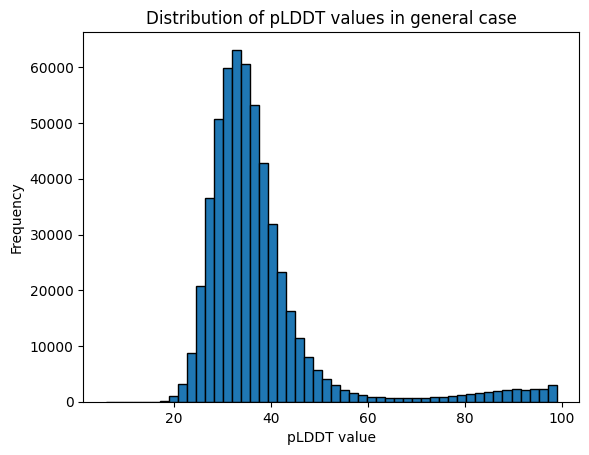

In [18]:
plt.hist(df1['plDDT'], bins=50, edgecolor='black')
plt.xlabel('pLDDT value')
plt.ylabel('Frequency')
plt.title('Distribution of pLDDT values in general case')
plt.show()

In [19]:
df1.describe()['plDDT']['mean'].item()

37.5867821919157

In [20]:
df1.describe()['plDDT']['75%'].item()

39.56999969

In [21]:
df1.describe()['plDDT']['max'].item()

98.94999695

#### Based on the mean value of 37.6, we can conclude that the pLDDT value is low when observed in the general case. Additionally, the 0.75 quantile value of 39.6 suggests the same, indicating that 75% of the pLDDT values in the dataset are below this value. But we can observe that the data also contains cases with extremely high pLDDT values – as high as 98.95. Also if we look at the data distribution, it is clear that while high pLDDT values do occur, very low values are predominant.

In [22]:
def analysis_of_score(score: str, structure: str, structure_name: str, data):
    """
    Input:
        score is either RSA or pLDDT,
        structure is a string of structure abbreviation separated by "-"
        structure_name is a full name of structure
    """
    if score == 'RSA':
        data[score] = data[['RSA1', 'RSA2']].mean(axis=1)
    score_df = data.groupby(structure.split('-'), as_index=False)[score].mean()
    display(score_df)
    mean_score = score_df.describe()[score]['mean']
    if score == 'plDDT':
        confident_scores = score_df[score_df[score] >= 70][score].count().item()
        print(f"Number of pairs with confident {score} value: {confident_scores}")
        display(score_df.describe())
        
        lean = mean_score >= 50 
        result_message=f"""
### Analysis of {structure_name} pairs and {score}:

#### According to the results, we determine that when observing the **{score}** values in relation to the **{structure_name}s** (in rare transitions), high values occur in **{confident_scores}** out of **{score_df.shape[0]}** {structure_name} pairs - in **{confident_scores * 100 / score_df.shape[0]:.2f}%** of them.

#### Additionally, the average **{score}** value in relation to the **{structure_name}s** is **{mean_score:.2f}**, which suggests that in this case, the value tends to **{'lean' if lean else 'not lean'}** towards confident, i.e., high.
        """
        display(Markdown(result_message))
    elif score == 'RSA':
        display(score_df.describe())
        
        exposed = score_df[score_df[score] >= 25].shape[0]
        buried = score_df[score_df[score] < 25].shape[0]
        print(f"Number of exposed residues: {exposed} and number of buried residues: {buried}")
        
        lean = mean_score >= 25
        result_message = f"""
### Analysis of {structure_name} pairs and {score}:

#### According to the results, we determine that when observing the **{score}** values in relation to the **{structure_name}s** (in rare transitions) exposed residues make up **{exposed * 100 / (exposed + buried):.2f}%** of the data.
#### Additionally, the average **{score}** value in relation to the **{structure_name}s** is **{mean_score:.2f}**, which suggests that in this case, the value tends to **{'lean' if lean else 'not lean'}** towards high and therefore the conclusion is that residues are mostly **{'exposed' if lean else 'buried'}**.
"""
        if mean_score >= 85:
            result_message += " #### The average value also indicates that it is a case of very high exposure."
        display(Markdown(result_message))

### The pLDDT value in relation to protein blocks:

In [23]:
analysis_of_score('plDDT', 'PB1-PB2', 'protein block', df1)

,PB1,PB2,plDDT
0,a,a,44.339518
1,a,i,38.255764
2,a,l,55.938937
3,a,n,80.694787
4,a,o,67.613355
...,...,...,...
101,p,i,52.431239
102,p,k,79.513161
103,p,n,88.728642
104,p,o,84.793949


Number of pairs with confident plDDT value: 49


,plDDT
count,106.000000
mean,63.454415
std,18.023050
min,33.597163
25%,45.888131
50%,65.646074
75%,79.848490
max,90.566951



### Analysis of protein block pairs and plDDT:

#### According to the results, we determine that when observing the **plDDT** values in relation to the **protein blocks** (in rare transitions), high values occur in **49** out of **106** protein block pairs - in **46.23%** of them.

#### Additionally, the average **plDDT** value in relation to the **protein blocks** is **63.45**, which suggests that in this case, the value tends to **lean** towards confident, i.e., high.
        

### The pLDDT value in relation to amino acids:

In [24]:
analysis_of_score('plDDT', 'AA1-AA2', 'amino acid', df1)

,AA1,AA2,plDDT
0,A,A,36.279311
1,A,C,36.472872
2,A,D,37.826370
3,A,E,35.691063
4,A,F,36.053551
...,...,...,...
395,Y,S,35.680825
396,Y,T,37.932608
397,Y,V,50.720816
398,Y,W,51.626279


Number of pairs with confident plDDT value: 0


,plDDT
count,400.000000
mean,38.670799
std,3.802211
min,33.752673
25%,36.140094
50%,37.688579
75%,39.974417
max,61.994733



### Analysis of amino acid pairs and plDDT:

#### According to the results, we determine that when observing the **plDDT** values in relation to the **amino acids** (in rare transitions), high values occur in **0** out of **400** amino acid pairs - in **0.00%** of them.

#### Additionally, the average **plDDT** value in relation to the **amino acids** is **38.67**, which suggests that in this case, the value tends to **not lean** towards confident, i.e., high.
        

### The pLDDT value in relation to secondary structures:

In [25]:
analysis_of_score('plDDT', 'S2_1-S2_2', 'secondary structure', df1)

,S2_1,S2_2,plDDT
0,B,B,81.062105
1,B,C,66.117487
2,B,E,95.586667
3,B,G,86.340001
4,B,H,95.203334
...,...,...,...
53,T,G,81.606257
54,T,H,75.952927
55,T,P,56.550000
56,T,S,63.890869


Number of pairs with confident plDDT value: 40


,plDDT
count,58.000000
mean,73.448625
std,15.828469
min,35.300866
25%,65.967828
50%,78.462409
75%,85.288241
max,95.586667



### Analysis of secondary structure pairs and plDDT:

#### According to the results, we determine that when observing the **plDDT** values in relation to the **secondary structures** (in rare transitions), high values occur in **40** out of **58** secondary structure pairs - in **68.97%** of them.

#### Additionally, the average **plDDT** value in relation to the **secondary structures** is **73.45**, which suggests that in this case, the value tends to **lean** towards confident, i.e., high.
        

## RSA - relative solvent accessibility

#### Relative accessible surface area or relative solvent accessibility (RSA) of a protein residue is a measure of residue solvent exposure. Threshold definitions vary, however, in most cases for comparing with other methods the threshold is defined as 25% of RSA value, resulting in a residue being classified as buried (defined as the RSA value is less than 25%) or exposed.

In [26]:
df1.describe()

,Protein_number,res_number,expected_frequency,plDDT,RSA1,RSA2
count,538901.000000,5.389010e+05,538901.000000,538901.000000,538901.000000,538901.000000
mean,12390.852606,7.558885e+06,0.393393,37.586782,92.459126,92.818022
std,6644.697647,4.333520e+06,0.258888,13.145442,18.013535,17.934032
min,0.000000,7.000000e+00,0.000000,5.920000,0.000000,0.000000
25%,7104.000000,3.939991e+06,0.179394,30.540001,93.450485,94.594597
50%,12627.000000,7.666910e+06,0.470296,34.570000,100.000000,100.000000
75%,17793.000000,1.118601e+07,0.618854,39.570000,100.000000,100.000000
max,23508.000000,1.490929e+07,0.900139,98.949997,100.000000,100.000000


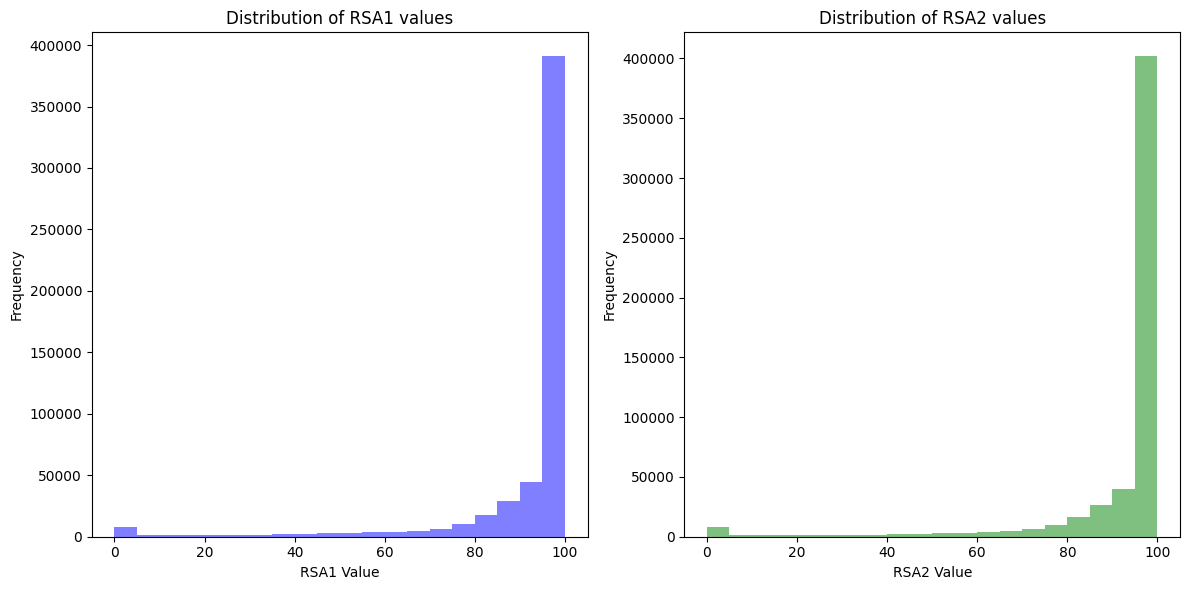

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(df1['RSA1'], bins=20, alpha=0.5, color='blue')
axs[0].set_xlabel('RSA1 Value')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of RSA1 values')

axs[1].hist(df1['RSA2'], bins=20, alpha=0.5, color='green')
axs[1].set_xlabel('RSA2 Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of RSA2 values')

plt.tight_layout()

In [28]:
mean_RSA1 = df1['RSA1'].mean()
median_RSA1 = df1['RSA1'].median()
quantile_0_75_RSA1 = df1['RSA1'].quantile(0.75)
print(f"For entire data set mean RSA1 is {mean_RSA1}, median is {median_RSA1} and 0.75 quantile is {quantile_0_75_RSA1}")
mean_RSA2 = df1['RSA2'].mean()
median_RSA2 = df1['RSA2'].median()
quantile_0_75_RSA2 = df1['RSA2'].quantile(0.75)
print(f"For entire data set mean RSA2 is {mean_RSA2}, median is {median_RSA2} and 0.75 quantile is {quantile_0_75_RSA1}")

For entire data set mean RSA1 is 92.45912572431887, median is 100.0 and 0.75 quantile is 100.0
For entire data set mean RSA2 is 92.81802177493898, median is 100.0 and 0.75 quantile is 100.0


In [29]:
exposed_RSA1 = df1[df1['RSA1'] >= 25].shape[0]
buried_RSA1 = df1[df1['RSA1'] < 25].shape[0]
exposed_RSA2 = df1[df1['RSA2'] >= 25].shape[0]
buried_RSA2 = df1[df1['RSA2'] < 25].shape[0]

In [30]:
print(f"Number of exposed residues: {exposed_RSA1 + exposed_RSA2} and number of buried residues: {buried_RSA1 + buried_RSA2}")

Number of exposed residues: 1050252 and number of buried residues: 27550


### Conclusion based on the analysis of the entire dataset:

#### Based on the analysis of the entire dataset, we conclude that **97.5% of the residues are exposed to the solvent**, while only **2.5% of the residues are buried**. This high percentage of exposed residues clearly indicates that the majority of residues are **predominantly exposed**.

#### Moreover, the **mean value** of approximately **92%**, as well as the **median** and **0.75 quantile** both reaching as high as **100%**, further reinforce the conclusion that the residues are highly exposed i.e. RSA values are high.

### The RSA value in relation to protein blocks:

In [31]:
analysis_of_score('RSA', 'PB1-PB2', 'protein block', df1)

,PB1,PB2,RSA
0,a,a,85.991507
1,a,i,92.705980
2,a,l,77.744388
3,a,n,43.888293
4,a,o,57.355803
...,...,...,...
101,p,i,76.213352
102,p,k,48.278867
103,p,n,33.302799
104,p,o,44.456570


,RSA
count,106.000000
mean,64.219617
std,20.352375
min,22.983397
25%,48.298345
50%,59.209232
75%,83.560475
max,96.876662


Number of exposed residues: 105 and number of buried residues: 1



### Analysis of protein block pairs and RSA:

#### According to the results, we determine that when observing the **RSA** values in relation to the **protein blocks** (in rare transitions) exposed residues make up **99.06%** of the data.
#### Additionally, the average **RSA** value in relation to the **protein blocks** is **64.22**, which suggests that in this case, the value tends to **lean** towards high and therefore the conclusion is that residues are mostly **exposed**.


### The RSA value in relation to amino acids:

In [32]:
analysis_of_score('RSA', 'AA1-AA2', 'amino acid', df1)

,AA1,AA2,RSA
0,A,A,97.495244
1,A,C,90.906358
2,A,D,93.880556
3,A,E,96.122249
4,A,F,88.422748
...,...,...,...
395,Y,S,93.190643
396,Y,T,88.086802
397,Y,V,65.555131
398,Y,W,70.367743


,RSA
count,400.000000
mean,89.822263
std,5.541973
min,65.555131
25%,87.107479
50%,90.880001
75%,93.854497
max,98.135047


Number of exposed residues: 400 and number of buried residues: 0



### Analysis of amino acid pairs and RSA:

#### According to the results, we determine that when observing the **RSA** values in relation to the **amino acids** (in rare transitions) exposed residues make up **100.00%** of the data.
#### Additionally, the average **RSA** value in relation to the **amino acids** is **89.82**, which suggests that in this case, the value tends to **lean** towards high and therefore the conclusion is that residues are mostly **exposed**.
 #### The average value also indicates that it is a case of very high exposure.

### The RSA value in relation to secondary structures:

In [33]:
analysis_of_score('RSA', 'S2_1-S2_2', 'secondary structure', df1)

,S2_1,S2_2,RSA
0,B,B,0.000000
1,B,C,22.707318
2,B,E,0.000000
3,B,G,8.273118
4,B,H,0.420080
...,...,...,...
53,T,G,58.596210
54,T,H,47.465168
55,T,P,85.633035
56,T,S,68.165864


,RSA
count,58.000000
mean,41.925664
std,30.019328
min,0.000000
25%,16.518614
50%,43.529417
75%,62.653578
max,97.473198


Number of exposed residues: 34 and number of buried residues: 24



### Analysis of secondary structure pairs and RSA:

#### According to the results, we determine that when observing the **RSA** values in relation to the **secondary structures** (in rare transitions) exposed residues make up **58.62%** of the data.
#### Additionally, the average **RSA** value in relation to the **secondary structures** is **41.93**, which suggests that in this case, the value tends to **lean** towards high and therefore the conclusion is that residues are mostly **exposed**.


## Overrepresented or underrepresented amino acids:

In [34]:
"""
Frequences observed in Veratbrates
"""
reference_frequencies = {'A' : 7.4,
                       'R' : 4.2,
                       'N' : 4.4,
                       'D' : 5.9,
                       'C' : 3.3,
                       'Q' : 3.7,
                       'E' : 5.8,
                       'G' : 7.4,
                       'H' : 2.9,
                       'I' : 3.8,
                       'L' : 7.6,
                       'K' : 7.2,
                       'M' : 1.8,
                       'F' : 4.0,
                       'P' : 5.0,
                       'S' : 8.1,
                       'T' : 6.2,
                       'W' : 1.3,
                       'Y' : 3.3,
                       'V' : 6.8
                      }

In [35]:
total = df1.shape[0]
column1_frequencies = df1['AA1'].value_counts()
column2_frequencies = df1['AA2'].value_counts()
total_frequencies = column1_frequencies.add(column2_frequencies, fill_value=0)
total_frequencies = (total_frequencies / total) * 100
total_frequencies

A    14.846883
C     2.581179
D    10.296882
E    15.827397
F     3.769709
G    21.208905
H     4.926508
I     5.323983
K    11.088307
L    14.132466
M     2.889770
N     7.148252
P     8.484675
Q     9.926313
R    10.153813
S    28.252499
T    15.402087
V    10.064186
W     0.997029
Y     2.679156
Name: count, dtype: float64

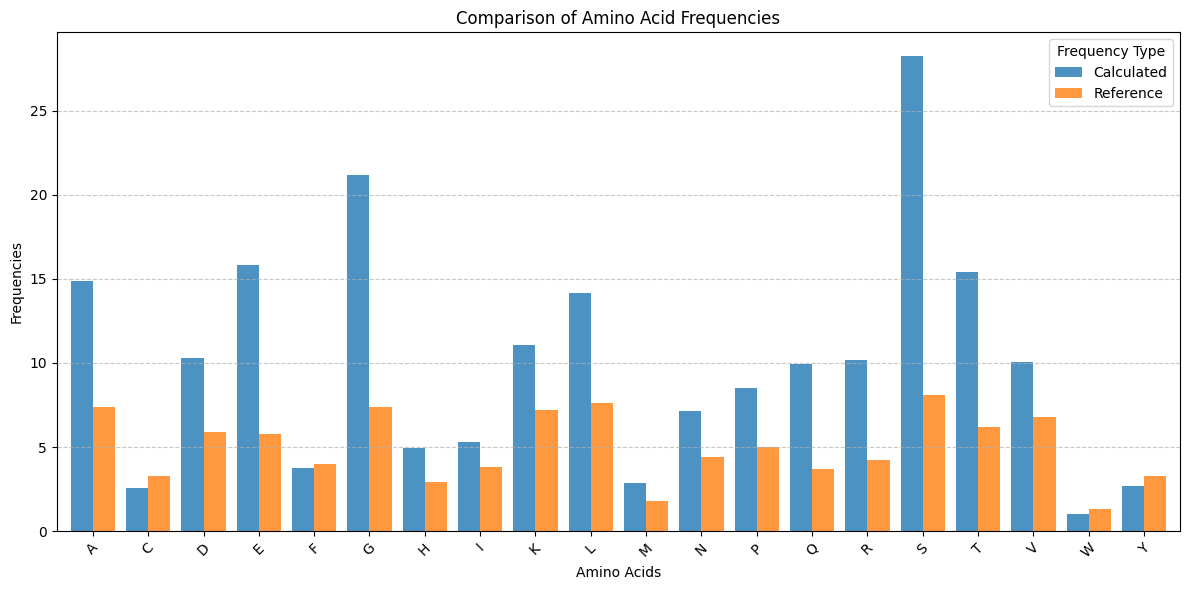

In [36]:
calculated_df = pd.Series(total_frequencies, name='Calculated')
reference_df = pd.Series(reference_frequencies, name='Reference')
comparison_df = pd.DataFrame({'Calculated': calculated_df, 'Reference': reference_df})

# Plot
comparison_df.plot(kind='bar', figsize=(12, 6), width=0.8, alpha=0.8)
plt.title("Comparison of Amino Acid Frequencies")
plt.xlabel("Amino Acids")
plt.ylabel("Frequencies")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Frequency Type")
plt.tight_layout()
plt.show()

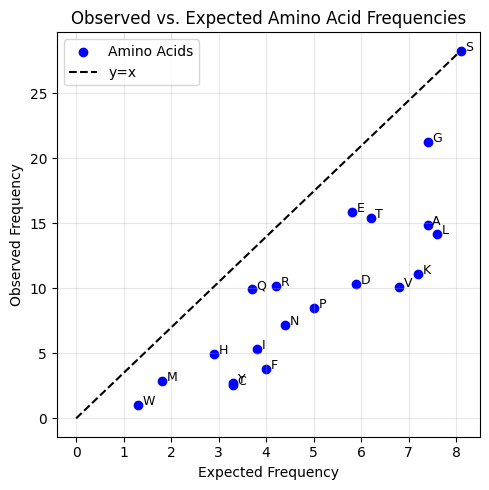

In [37]:
labels = list(total_frequencies.keys())
observed = list(total_frequencies.values)
expected = [reference_frequencies[label] for label in labels]

plt.figure(figsize=(5, 5))
plt.scatter(expected, observed, color='blue', label='Amino Acids')
plt.plot([0, max(expected)], [0, max(observed)], color='black', linestyle='--', label='y=x')

for i, label in enumerate(labels):
    plt.text(expected[i] + 0.1, observed[i], label, fontsize=9)

plt.title("Observed vs. Expected Amino Acid Frequencies")
plt.xlabel("Expected Frequency")
plt.ylabel("Observed Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()